In [1]:
from fastai.collab import *
from fastai.tabular.all import *
path = untar_data(URLs.ML_100k)

In [3]:
path.ls()

(#23) [Path('/Users/sagartr/.fastai/data/ml-100k/u.item'),Path('/Users/sagartr/.fastai/data/ml-100k/u3.test'),Path('/Users/sagartr/.fastai/data/ml-100k/u1.base'),Path('/Users/sagartr/.fastai/data/ml-100k/u.info'),Path('/Users/sagartr/.fastai/data/ml-100k/u2.test'),Path('/Users/sagartr/.fastai/data/ml-100k/u5.test'),Path('/Users/sagartr/.fastai/data/ml-100k/u.genre'),Path('/Users/sagartr/.fastai/data/ml-100k/ub.test'),Path('/Users/sagartr/.fastai/data/ml-100k/ua.base'),Path('/Users/sagartr/.fastai/data/ml-100k/u.data')...]

In [4]:
ratings = pd.read_csv(path/'u.data', delimiter='\t',header=None,
                      names=['user', 'movie', 'rating', 'timestamp'])
ratings.head()

,user,movie,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [5]:
movies= pd.read_csv(path/'u.item',  delimiter='|',encoding='latin-1',
                    usecols=(0,1),names=('movie', 'title'), header=None)
movies.head()

,movie,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [6]:
ratings = ratings.merge(movies)
ratings.head()

,user,movie,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,186,302,3,891717742,L.A. Confidential (1997)
2,22,377,1,878887116,Heavyweights (1994)
3,244,51,2,880606923,Legends of the Fall (1994)
4,166,346,1,886397596,Jackie Brown (1997)


In [7]:
ratings.rating.unique()

array([3, 1, 2, 4, 5])

Cross entropy loss:
$$ H(y, \hat{y}) = \sum_i y_i \log \frac{1}{\hat{y}_i} = -\sum_i y_i \log \hat{y}_i $$

But the rating have 1 to 5 indexing like this will fail as tesnor 0<sup>th</sup>. 

In [8]:
ratings.rating = ratings.rating -1
ratings.rating.unique()

array([2, 0, 1, 3, 4])

In [9]:
dls = CollabDataLoaders.from_df(ratings, user_name='user', item_name='title', rating_name='rating', bs=64)
dls.show_batch()

,user,title,rating
0,178,Grumpier Old Men (1995),2
1,625,"Boot, Das (1981)",3
2,530,"Game, The (1997)",2
3,327,Sense and Sensibility (1995),3
4,798,Batman (1989),3
5,603,True Lies (1994),3
6,327,"Die xue shuang xiong (Killer, The) (1989)",2
7,592,Heat (1995),4
8,909,Cold Comfort Farm (1995),4
9,89,Much Ado About Nothing (1993),3


In [10]:
class CollabNNCEL(Module):
    def __init__(self, user_sz, movie_sz, n_act=100):
        self.user_factors = Embedding(*user_sz)
        self.movie_factors = Embedding(*movie_sz)

        self.layers = nn.Sequential(
            nn.Linear(user_sz[1] + movie_sz[1], n_act),
            nn.ReLU(),
            nn.Linear(n_act, 5),
            nn.Softmax(dim=1),
        )

    
    def forward(self, x):
        embds = self.user_factors(x[:,0]), self.movie_factors(x[:,1])

        x = self.layers(torch.cat(embds, dim=1))
        return x

In [11]:
embs = get_emb_sz(dls)
embs

[(944, 74), (1665, 102)]

In [12]:
model = CollabNNCEL(*embs)

In [13]:
X, Y = dls.one_batch()
X.shape, Y.shape

(torch.Size([64, 2]), torch.Size([64, 1]))

In [14]:
y_pred = model.forward(X)
y_pred.shape, y_pred[0].sum()

(torch.Size([64, 5]), tensor(1., grad_fn=<SumBackward0>))

In [15]:
Y.shape, Y.squeeze().shape, Y.shape[0]

(torch.Size([64, 1]), torch.Size([64]), 64)

In [16]:
arr = [i for i in range(64)]
y_pred[arr,Y.squeeze().long()].shape, y_pred[arr,Y.squeeze().long()].mean()

(torch.Size([64]), tensor(0.1987, grad_fn=<MeanBackward0>))

In [17]:
def loss_func(pred, target):
    arr = [i for i in range(target.shape[0])]
    return pred[arr,target.squeeze().long()].mean()

In [18]:
loss_func(y_pred, Y)

tensor(0.1987, grad_fn=<MeanBackward0>)

In [20]:
learn_CE = Learner(dls, model, loss_func=loss_func)
learn_CE.fit_one_cycle(5, 5e-3, wd=0.01)

epoch,train_loss,valid_loss,time
0,0.034876,0.043572,00:36
1,0.035086,0.037512,00:42
2,0.028864,0.035261,00:49
3,0.024046,0.034061,00:38
4,0.024624,0.033833,00:46


In [29]:
movie_embedding = model.movie_factors
idx = dls.classes['title'].o2i['Silence of the Lambs, The (1991)'] #extract the index of the movie
idx

1330

In [32]:
movie_embedding

Embedding(1665, 102)

In [36]:
movie_embedding.weight[idx].shape

torch.Size([102])

In [38]:
mov_embd = movie_embedding.weight[idx][None]
idx, mov_embd.shape

(1330, torch.Size([1, 102]))

In [39]:
cos = nn.CosineSimilarity(dim=1)
dist = cos(movie_embedding.weight, mov_embd)

In [40]:
dist[idx]

tensor(1., device='mps:0', grad_fn=<SelectBackward0>)

In [42]:
dls.classes['title'][dist.argsort(descending=True)[:10]]

(#10) ['Silence of the Lambs, The (1991)','While You Were Sleeping (1995)',"Mr. Holland's Opus (1995)",'Raiders of the Lost Ark (1981)','Godfather, The (1972)','Glory (1989)','Amadeus (1984)','Star Wars (1977)','Bronx Tale, A (1993)','Citizen Kane (1941)']

In [43]:
g = ratings.groupby('title')['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_idxs = tensor([learn_CE.dls.classes['title'].o2i[m] for m in top_movies])

In [47]:
movie_w = learn_CE.model.movie_factors.weight[top_idxs].cpu().detach()

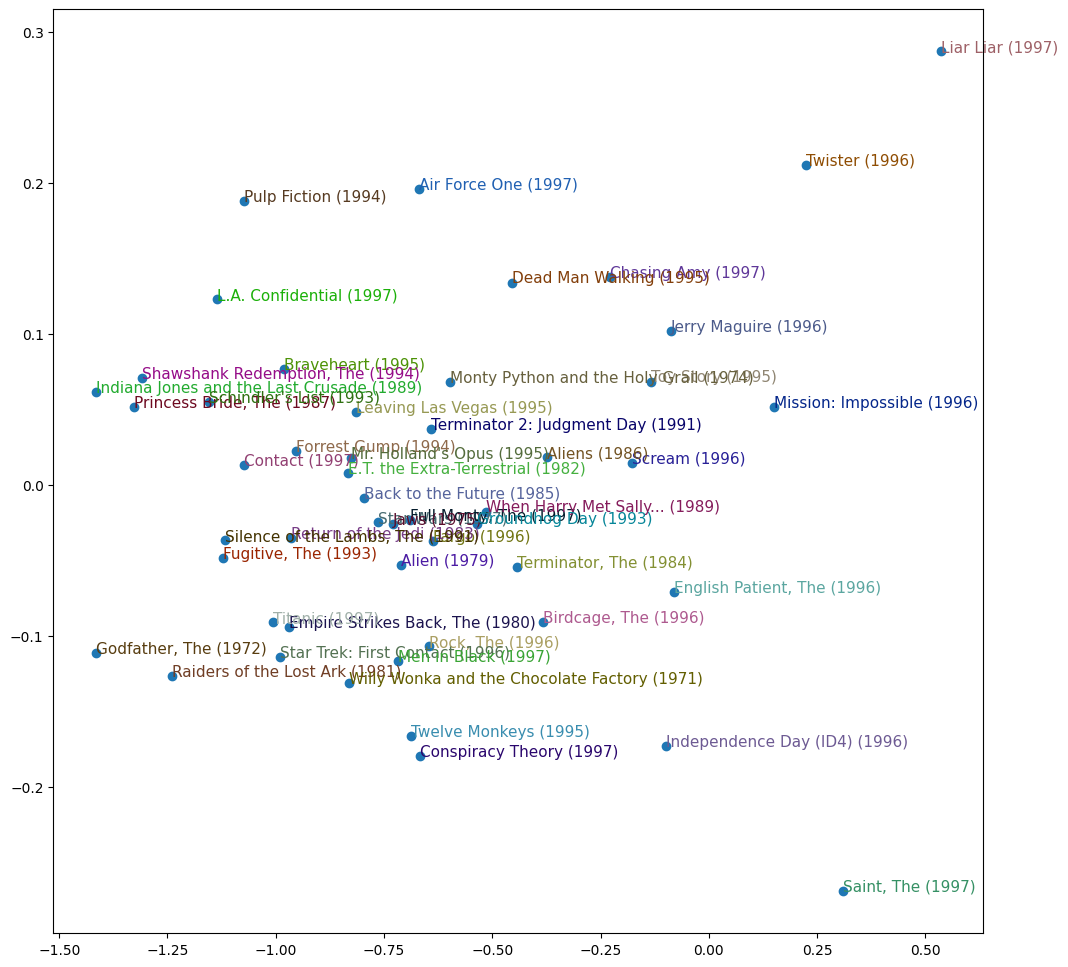

In [49]:
movie_pca = movie_w.pca(3)
fac0,fac1,fac2 = movie_pca.t()
idxs = list(range(50))
X = fac0[idxs]
Y = fac1[idxs]
plt.figure(figsize=(12,12))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()